# MAPseq Data Analysis

In this notebook, we will take the combined bulk RNAseq from all MAPseq target areas. 

## Imports

In [32]:
import logging
import os
import sys
from configparser import ConfigParser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling barcode tags with letters and numbers. 
from natsort import natsorted

# Allowing to run from git. 
gitpath=os.path.expanduser("~/git/mapseq-processing")
sys.path.append(gitpath)

from mapseq.core import *
from mapseq.barcode import *
from mapseq.utils import *
from mapseq.bowtie import *

logging.getLogger().setLevel(logging.DEBUG)

print("Done")

Done


## Configuration, logging, and paths for analysis
We need to provide paths to the two fastq read files (either fastq or fastq.gz), the barcode (SSI) sequences for different target areas, and a standard sample info Excel spreadsheet. 


In [11]:
cp = get_default_config()
logging.getLogger().setLevel(logging.INFO)
sampleinfo = os.path.expanduser('~/project/mapseq/M205test/M205_sampleinfo.xlsx')
barcodes = os.path.expanduser('~/project/mapseq/M205test/barcode_v2.txt')
outdir = os.path.expanduser('~/project/mapseq/M205test/fastq.out')
infiles = [
    os.path.expanduser('~/project/mapseq/M205test/fastq/M205_S1_R1_001.fastq.gz'),
    os.path.expanduser('~/project/mapseq/M205test/fastq/M205_S1_R2_001.fastq.gz')
          ]
print("Done")

Done


In [6]:
sampdf = load_sample_info(cp, sampleinfo)
# extract list of actually used primers.
rtlist = list(sampdf.rtprimer.dropna())
rtlist = [int(x) for x in rtlist]
rtlist = [ f'BC{x}' for x in rtlist]
rtlist
# make barcode handler objects
bcolist = load_barcodes(cp, barcodes, labels=rtlist, outdir=outdir)
print(len(bcolist))
sampdf = sampdf[sampdf['rtprimer'].notna()]
sampdf.rtprimer = sampdf.rtprimer.astype(int)
of = f'{outdir}/sampleinfo.tsv'
sampdf.to_csv(of, sep='\t')
rtlist
sampdf

26


/Users/jhover/miniconda3/envs/mapseq/lib/python3.9/site-packages/pandas/core/series.py:917: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


,usertube,samplename,ourtube,siteinfo,rtprimer,brain,region
0,OB,Olfactory Bulb,1,target-negative,1,YW143,OB
1,ACB,ACB,2,target,2,YW143,ACB
2,AI,AI,3,target,3,YW143,AI
3,CP,CP (dorsal part - can just dissect out the top...,4,target,4,YW143,CP
4,MTN,MTN,5,target,5,YW143,MTN
5,BLAa,BLAa,6,target,6,YW143,BLAa
6,PIR,Piriform Cortex,7,target,7,YW143,PIR
7,VTA,VTA,8,target,8,YW143,VTA
8,TeA,TeA,9,target,9,YW143,TeA
9,ENTl,ENTl,10,target,10,YW143,ENTl


2023-10-25 10:52:51,923 (UTC) [ INFO ] barcode.py:193 root.check_output(): all output exists.
2023-10-25 10:52:51,923 (UTC) [ WARNING ] core.py:988 root.process_fastq_pairs(): all output exists and force=False. Not recalculating.
2023-10-25 10:52:51,924 (UTC) [ INFO ] core.py:993 root.process_fastq_pairs(): Making counts df for ['/Users/jhover/project/mapseq/M205test/fastq.out/BC1.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC2.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC3.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC4.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC5.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC6.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC7.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC8.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC9.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC10.fasta', '/Users/jhover/project/mapseq/M205test/fastq.out/BC11.fast

TypeError: string indices must be integers

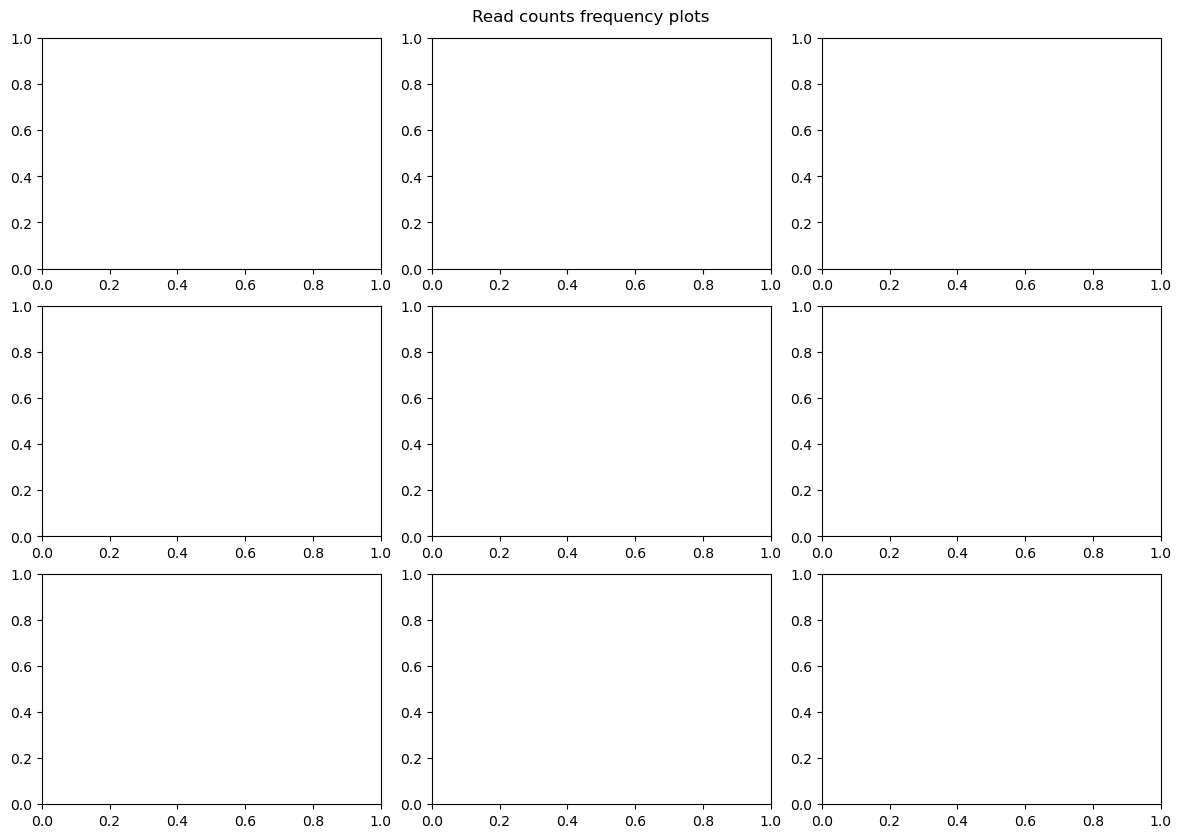

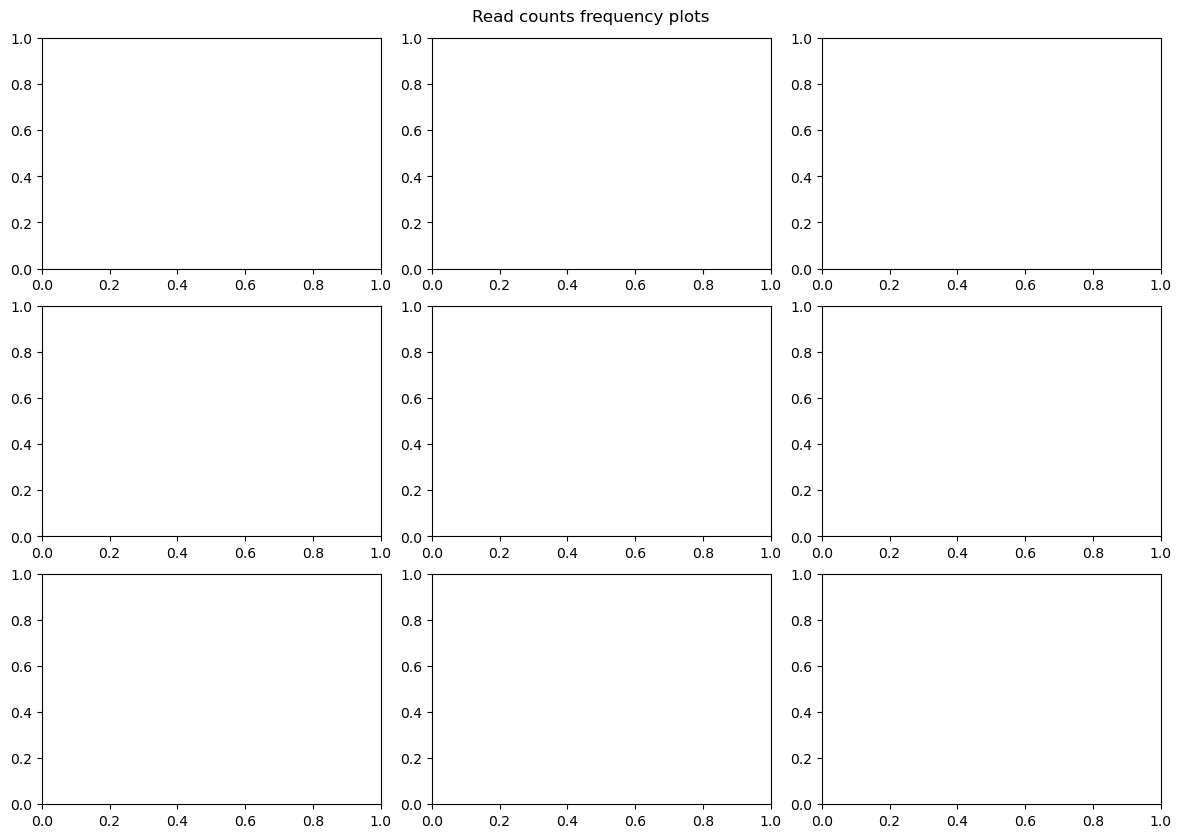

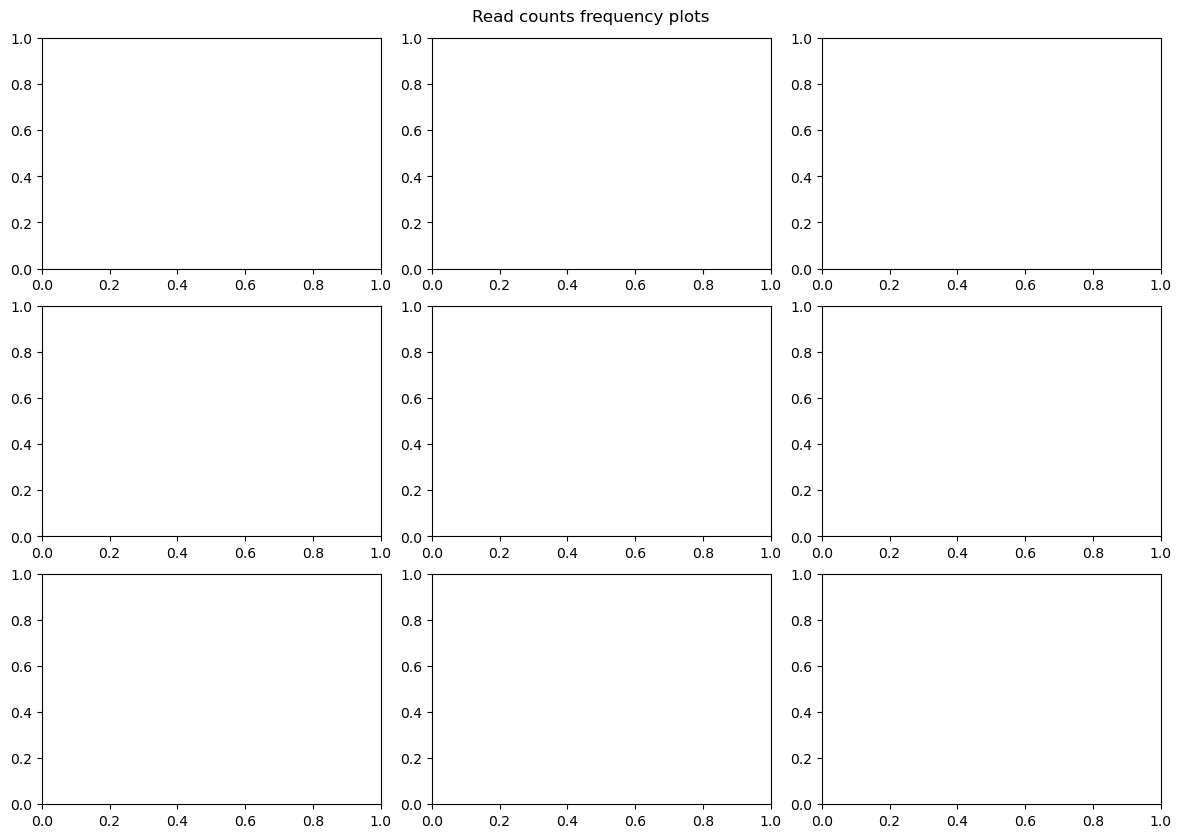

['SSI285.real.tsv',
 'SSI284.real.tsv',
 'unmatched.fasta',
 'BC283.fasta',
 'BC281.fasta',
 'SSI283.spike.tsv',
 'SSI287.lone.tsv',
 'SSI288.spike.tsv',
 'BC285.fasta',
 'SSI288.all.tsv',
 'merge_areas.config.202305252144.txt',
 'SSI285.spike.tsv',
 'BC287.fasta',
 'SSI281.all.tsv',
 'process_ssifasta.config.202305081548.txt',
 'seq',
 'SSI283.all.tsv',
 'BC282.fasta',
 'SSI282.spike.tsv',
 'SSI282.real.tsv',
 'SSI283.real.tsv',
 'SSI282.all.tsv',
 'old',
 'SSI288.real.tsv',
 'process_ssifasta.config.202305081559.txt',
 'SSI284.spike.tsv',
 'SSI281.lone.tsv',
 'process_ssifasta.config.202305081558.txt',
 'BC284.fasta',
 'process_ssifasta.config.202305081541.txt',
 'process_ssifasta.config.202305081555.txt',
 'BC288.fasta',
 'paired.txt',
 'bowtie',
 'process_ssifasta.config.202305081554.txt',
 'process_ssifasta.config.202305081540.txt',
 'SSI281.spike.tsv',
 'SSI287.all.tsv',
 'process_ssifasta.config.202305081547.txt',
 'sampleinfo.tsv',
 'SSI285.lone.tsv',
 'SSI284.lone.tsv',
 'proc

In [8]:
# handle all the input. usually takes ~ minutes
# M229. 297M reads. 
process_fastq_pairs(cp, infiles[0], infiles[1], bcolist, outdir=outdir, force=False)
os.listdir(outdir)

In [15]:
tdflist = []
cdflist = []
outcdf = None
for bch in bcolist:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    of = f'{dirname}/{base}.tsv'
    seqdf = make_fasta_df(cp, bch.filename)
    cdf = make_counts_df(cp, seqdf, label=bch.label)  
    cdflist.append(cdf)
    if bch.label == 'BC4':
        outcdf = cdf
    count_threshold, label, clength, counts_max, counts_min = calculate_threshold(cp, cdf)
    tdf = threshold_counts(cp, cdf, threshold=count_threshold)
    tdf['counts'] = 1
    tdf['sequence'] = tdf['sequence'].str[:32]
    bch.dataframe = make_counts_df(cp, tdf)
    tdflist.append(tdf)
alldf = BarcodeHandler.merge_counts(cp, tdflist)
alldf['logcounts'] = np.log(alldf.counts)
alldf 

2023-10-25 11:18:14,196 (UTC) [ INFO ] core.py:640 root.calculate_threshold(): handling BC1 length=4758 max=8 min=1 
2023-10-25 11:18:14,198 (UTC) [ WARNING ] core.py:644 root.calculate_threshold(): calc threshold < min...
2023-10-25 11:18:15,608 (UTC) [ INFO ] core.py:640 root.calculate_threshold(): handling BC2 length=102929 max=8 min=1 
2023-10-25 11:18:15,610 (UTC) [ WARNING ] core.py:644 root.calculate_threshold(): calc threshold < min...
2023-10-25 11:18:15,937 (UTC) [ INFO ] core.py:640 root.calculate_threshold(): handling BC3 length=20370 max=11 min=1 
2023-10-25 11:18:15,940 (UTC) [ WARNING ] core.py:644 root.calculate_threshold(): calc threshold < min...
2023-10-25 11:18:21,747 (UTC) [ INFO ] core.py:640 root.calculate_threshold(): handling BC4 length=379122 max=10 min=1 
2023-10-25 11:18:21,751 (UTC) [ WARNING ] core.py:644 root.calculate_threshold(): calc threshold < min...
2023-10-25 11:18:24,042 (UTC) [ INFO ] core.py:640 root.calculate_threshold(): handling BC5 length=14

,label,sequence,counts,logcounts
0,BC1,GCTTTACTAAACTCTTCCTTGCCATTGAATTC,1,0.0
1,BC1,AACACCAGCAAGTGGAGGGTTATGCGCGTACT,1,0.0
2,BC1,ATTCTCAGGTAAATGGCGCCGCTTAATTTATC,1,0.0
3,BC1,GTTTCACCCGGTCTGCACGCGCCAGCCACCCG,1,0.0
4,BC1,CTGGAGCTGCGATGTCGTTAACGCCGTCAGTC,1,0.0
...,...,...,...,...
3539371,BC26,TAGCATATTCGGTTGTTGCTCTAACGTCAGTC,1,0.0
3539372,BC26,GGTCTGACACGGGACGCGTGAGGTCGTCAGTC,1,0.0
3539373,BC26,CTACCCTAGCGCGGCGAGTATCCCCGTCAGTC,1,0.0
3539374,BC26,GAGGGAGTCAAAGGGCTGAGGTACCTCCCATC,1,0.0


In [22]:
outcdf = cdflist[3]
cdflist

[                                          sequence  counts label
 0     GCTTTACTAAACTCTTCCTTGCCATTGAATTCACCCTGCGCACG       8   BC1
 1     AACACCAGCAAGTGGAGGGTTATGCGCGTACTCCTATACAACAA       7   BC1
 2     ATTCTCAGGTAAATGGCGCCGCTTAATTTATCGACTAATAGGGA       7   BC1
 3     GTTTCACCCGGTCTGCACGCGCCAGCCACCCGATAAGGCATTCT       6   BC1
 4     CTGGAGCTGCGATGTCGTTAACGCCGTCAGTCATATTTACTAAA       6   BC1
 ...                                            ...     ...   ...
 4753  TGTAATACGATGACGCTTTTACGCCGTCAGTCGTAGGTAAATGA       1   BC1
 4754  TGCTCAATTTCTCAGCGTCTCGCCTAGAAACCAAAGTGAGGTGT       1   BC1
 4755  GCCAGTTCTACAGCAGCCCGCCTAAACCTTTTTGATGTAAGCTC       1   BC1
 4756  AATCGCTGCTAACTTTCGGCCGAAAGGGGTTTGCGTAAGATCTC       1   BC1
 4757  CTTGGATTTAATTGCTAATTTCTTCGTCAGTCTAACGGGGGCAC       1   BC1
 
 [4758 rows x 3 columns],
                                             sequence  counts label
 0       TCCAACTTGGGGGGCTTAGCGTATCGATGTCCTACGGTAAACTC       8   BC2
 1       ACTCTGGCTGAATCATTAGATAGACAAGGGTCAAT

In [23]:
outcdf[outcdf.counts > 0]
outcdf['logcounts'] = np.log(outcdf.counts)
outcdf

,sequence,counts,label,logcounts
0,ATCCATTTTTGGATATCCTAATTTAACAGGCTCTTTCGGCTTCA,10,BC4,2.302585
1,ATTCCGTGGCAGGAGGGGCTGGACTGGGGCTCTACGCGGTCAGT,10,BC4,2.302585
2,CAGATGCGTATCGAAAATTGCCTCGTGGTTCCAAGTTCCCACGG,10,BC4,2.302585
3,ACTGTTTACCCAGACATCTTGCCCGCTGCGTTAGGAAGCAGTCC,9,BC4,2.197225
4,ATAGACAAGCCTAATACTTCCCGCGGCGCTTGTCCATACTAACG,9,BC4,2.197225
...,...,...,...,...
379117,CAGTATGTATTTAAGTATCTATAACGTACTCCGTCCAGGGGCTC,1,BC4,0.000000
379118,TCTACCATGGTGCGAGGCTTTATGCGTGGGCTATCAAGTCAACC,1,BC4,0.000000
379119,GGGTGGGGTTCTGCAGTTATCCGAGTTGACTTAATTTGTTCGCG,1,BC4,0.000000
379120,TTTGATACTCCTCCAAGACCGGTTTGTTGTTCGTGTCGTTCCAA,1,BC4,0.000000


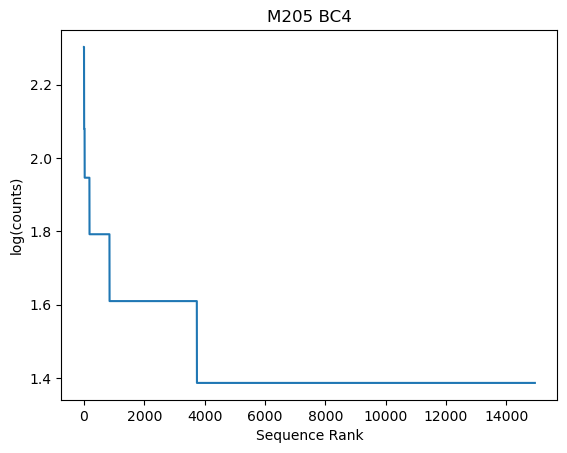

In [26]:
plotdf = outcdf[outcdf.counts > 3]
#plotdf['logcounts'] = np.log(plotdf.counts)
#  y axis. log of counts. 
#. x axis.  'sequence rank'

ax = sns.lineplot(data=plotdf, x= plotdf.index, y = 'logcounts')
ax.set(xlabel='Sequence Rank',
      ylabel='log(counts)',
      title = 'M205 BC4')
plt.show()

In [30]:
#graph = sns.FacetGrid(alldf, col = 'bc_label', hue='counts', col_wrap = 4, row_order='bc_label')
#graph.map(sns.lineplot, y="counts")
#plt.show()

In [28]:
# use BC4  as example 
# need to trim again to 32 length!!

reals =[]
spikes =[]
lones =[]

alldfs = []

for bch in bcolist[:1]:
    filepath = os.path.abspath(bch.filename)    
    dirname = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    (base, ext) = os.path.splitext(filename)
    
    outfile = trim_fasta(cp, bch.filename, length=32)
    seqdf = make_fasta_df(cp, outfile)
    df = make_counts_df(cp, seqdf, label=bch.label)
    bch.dataframe = df
    print(f'{bch.label} {len(df)}')
    (spikedf, realdf, lonedf) = split_spike_real_lone_barcodes(cp, df)

    realcdf = make_counts_df(cp, realdf)
    spikecdf = make_counts_df(cp, spikedf)
    lonecdf = make_counts_df(cp, lonedf)    
    
    print(realdf)
    
    acrealdf = align_and_collapse(cp, realdf, dirname, base, 'real')
    acspikedf = align_and_collapse(cp, spikedf, dirname, base, 'spike')
    aclonedf = align_and_collapse(cp, lonedf, dirname, base, 'lone')
    
    acrealdf['type'] = 'real'
    acspikedf['type'] = 'spike'
    aclonedf['type'] = 'lone'
    
    outdf = merge_dfs([ acrealdf, acspikedf, aclonedf ])
    outdf['bc_label'] = base
    outdf.sort_values(by = ['type', 'counts'], ascending = [True, False], inplace=True)
    outdf.reset_index(drop=True, inplace=True)
    alldfs.append(outdf)
    
alldfs
    
    #print(reals[0])

2023-10-25 11:25:33,399 (UTC) [ INFO ] core.py:801 root.split_spike_real_lone_barcodes(): initial=3615 spikeins=2639 real=787 lone=94
2023-10-25 11:25:33,420 (UTC) [ INFO ] core.py:262 root.align_and_collapse(): real 787 sequences, representing 2731 reads.


BC1 3615
                             sequence  counts label
0    TAAATGGACAACATCGTCCTAGGAATGAGTTC     257   BC1
1    TGTGAGTATCAATTTGTCCGTTTTCATCCACT      78   BC1
2    GCCGTTAAATTACTAGTAACCAGCCCGTCTCC      76   BC1
3    CAATGAGCTTGGGCAAGGGGGCGGGAGTCACT      72   BC1
4    GCTCTCGAGACGTTGTCATAGTATAGGCCCCC      68   BC1
..                                ...     ...   ...
782  TGACGTGGGTATTGTACGTTTGAGGGGCCCTC       1   BC1
783  AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC       1   BC1
784  TGTTCAGTCGAATAACTTTTTTACTTCTGTCT       1   BC1
785  GGGTTTTGGTCGTGGATGGGTGTGCAATCACC       1   BC1
786  TAGGTGTCTTTTTATAGGCTGTTAAGGAGTTC       1   BC1

[787 rows x 3 columns]


2023-10-25 11:25:35,436 (UTC) [ INFO ] core.py:262 root.align_and_collapse(): spike 2639 sequences, representing 4294 reads.
2023-10-25 11:25:40,925 (UTC) [ INFO ] core.py:262 root.align_and_collapse(): lone 94 sequences, representing 109 reads.


[                              sequence  counts label   type bc_label
 0     TGTATATCCGGGCTTGAACCGTCAGTCTCGGA       3   BC1   lone      BC1
 1     TCGCGACTTCGCGCTCAGAATGGGAGGTATAG       3   BC1   lone      BC1
 2     GATCGCTATCTGTGTGTGTATAGCTCCGTCAG       3   BC1   lone      BC1
 3     GGGGATGTAAGTAAATTCGAGGCGACGGCTGG       2   BC1   lone      BC1
 4     ATCTATCAGTTCCCGCTGGCAACGCGTAATGA       2   BC1   lone      BC1
 ...                                ...     ...   ...    ...      ...
 3463  GCGAGATCAATGGTTAAGGAACTCCGTCAGTC       1   BC1  spike      BC1
 3464  CAGATGTGAATCAAAGAGCAACTTCGTCAGTC       1   BC1  spike      BC1
 3465  GGGCCGGGGATGCTGGGGTGGGGACGTCAGTC       1   BC1  spike      BC1
 3466  AGGTACCACCGAGGTTGTAAAAGTCGTCAGTC       1   BC1  spike      BC1
 3467  CTTGGATTTAATTGCTAATTTCTTCGTCAGTC       1   BC1  spike      BC1
 
 [3468 rows x 5 columns]]

In [31]:
bch = bcolist[3]
print(bch.label)
base = 'BC3'
aligner = cp.get('ssifasta','tool')
of = os.path.join(outdir , f'{base}.real.seq.fasta')
logging.debug(f'make fasta for {aligner} = {of}') 
seqfasta = write_fasta_from_df(cp, realdf, outfile=of)
of = os.path.join(outdir , f'{base}.real.{aligner}')
afile = run_bowtie(cp, seqfasta, of, tool=aligner )  
btdf = make_bowtie_df(afile)
btdf

BC4


,name_read,strand,name_align,offset,seq,quals,ceil,mm_desc
0,0,+,0,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
1,0,+,391,0,TAAATGGACAACATCGTCCTAGGAATGAGTTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,13:A>T
2,1,+,1,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
3,1,+,694,0,TGTGAGTATCAATTTGTCCGTTTTCATCCACT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,6:C>T
4,2,+,2,0,GCCGTTAAATTACTAGTAACCAGCCCGTCTCC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
...,...,...,...,...,...,...,...,...
840,783,+,783,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
841,783,+,47,0,AGGCTTGTCGTACTAAGTCGCGGTTGGCGCTC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,11:G>A
842,784,+,784,0,TGTTCAGTCGAATAACTTTTTTACTTCTGTCT,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN
843,785,+,785,0,GGGTTTTGGTCGTGGATGGGTGTGCAATCACC,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII,0,NaN


2023-10-25 12:26:02,760 (UTC) [ DEBUG ] core.py:1483 root.process_merged(): ['/Users/jhover/project/mapseq/M205test/M205.all.tsv']
2023-10-25 12:26:02,761 (UTC) [ DEBUG ] utils.py:398 root.merge_tsvs(): merge list ['/Users/jhover/project/mapseq/M205test/M205.all.tsv']
/Users/jhover/git/mapseq-processing/mapseq/utils.py:401: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep='\t', index_col=0)
2023-10-25 12:26:03,208 (UTC) [ DEBUG ] utils.py:406 root.merge_tsvs(): merged 1 tsv files new df len=349817
2023-10-25 12:26:03,209 (UTC) [ DEBUG ] core.py:1486 root.process_merged(): alldf len=349817
2023-10-25 12:26:03,209 (UTC) [ DEBUG ] core.py:1505 root.process_merged(): running exp=MAPseq min_injection=30 min_target=2 cmap=Blues clustermap_scale=log2 
2023-10-25 12:26:03,240 (UTC) [ DEBUG ] core.py:1520 root.process_merged(): handling brain list: ['YW143', 'YW144']
2023-10-25 12:26:03,240 (UTC) [ DEBUG ] core.py:1523

KeyError: 0

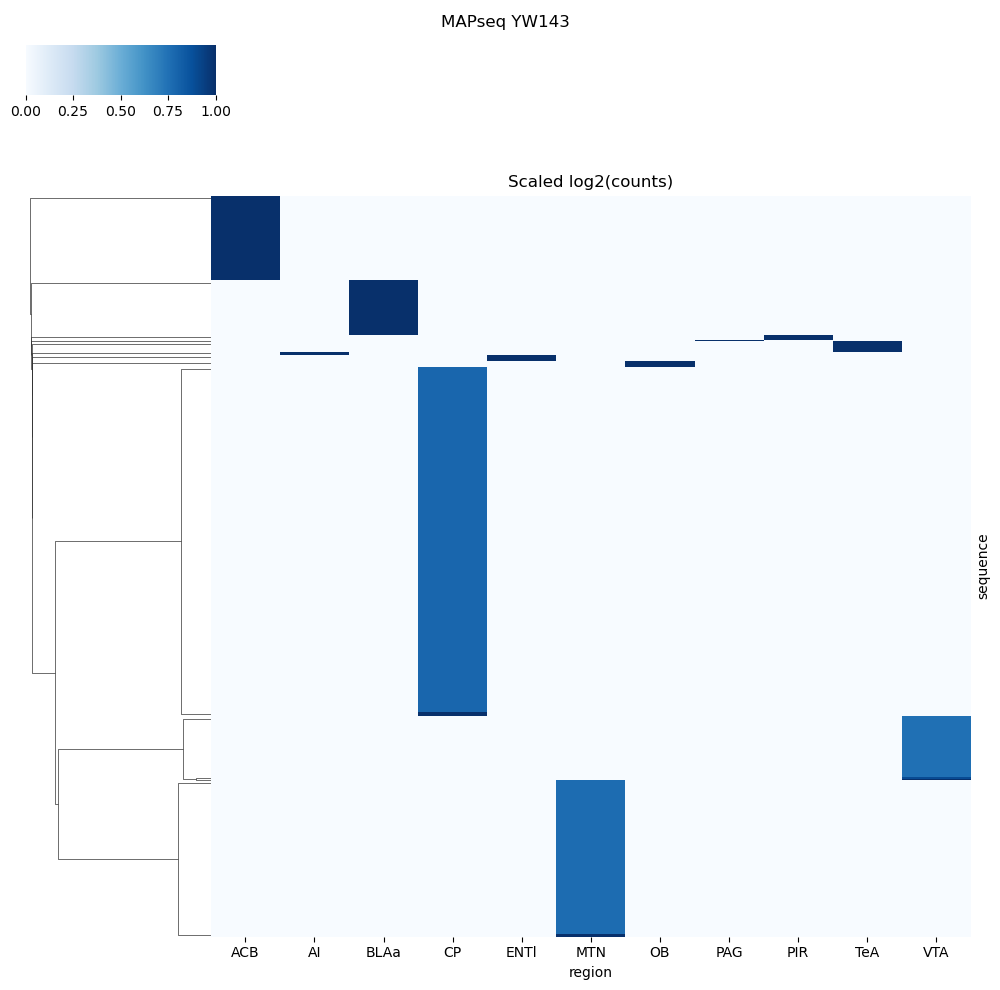

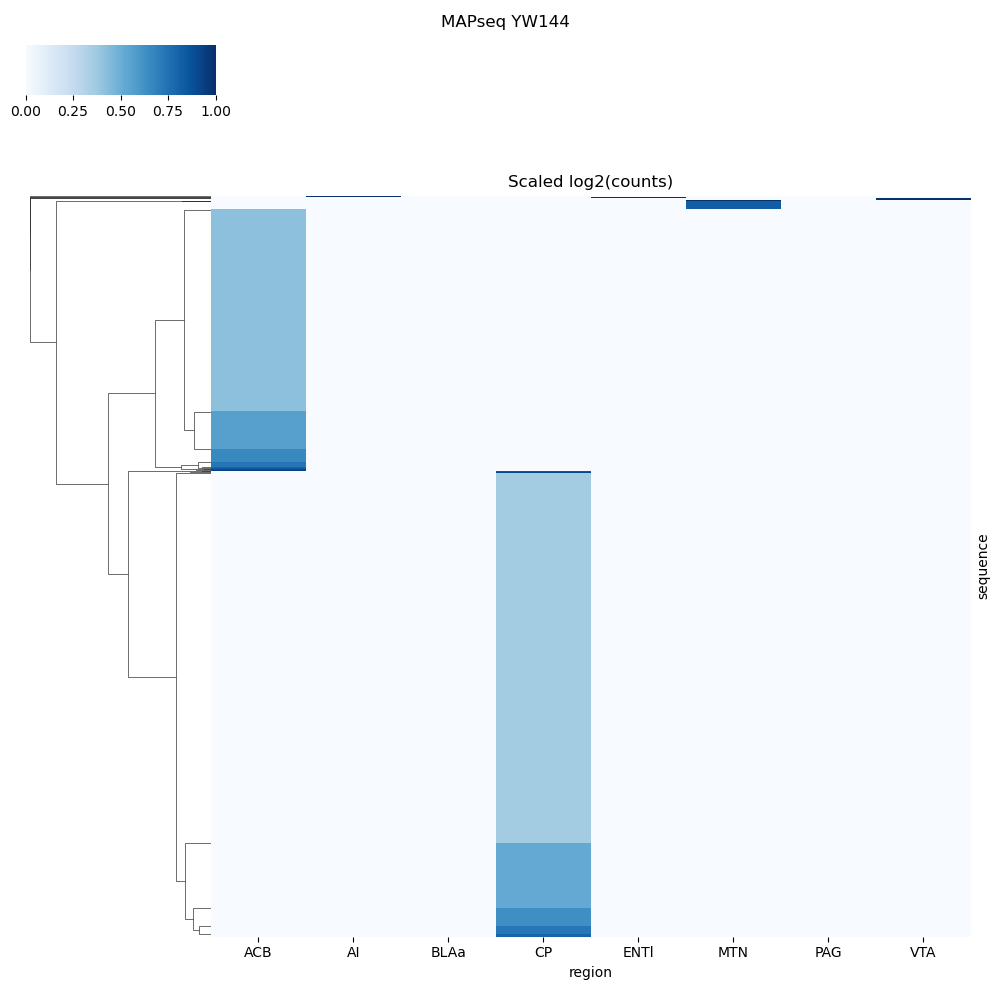

In [43]:
cp = get_default_config()
allfile = os.path.expanduser('~/project/mapseq/M205test/M205.all.tsv') 
brainlist = process_merged(cp, [ allfile ], outdir=None)
brainlist
#rbc, sbc, nbc = brainlist[0]

In [44]:
rbc

NameError: name 'rbc' is not defined